In [1]:
import re
import tomllib
from dataclasses import fields
from pathlib import Path
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes
from matplotlib.ticker import MultipleLocator
import pycountry_convert as pc

import seaborn as sns

from validation.geom_indices import GeomIndices
from validation.io import load_emdat_archive

with open('config.toml', 'rb') as f:
    config = tomllib.load(f)

MPL_CONFIG = {
    "font.family": "Aptos",
    "font.size": "8",
    "axes.titlesize": "6",
    "axes.labelsize": "6",
    "xtick.labelsize": "6",
    "ytick.labelsize": "6",
    "legend.fontsize": "6",
    "axes.linewidth": .5,
    "lines.linewidth": .5,
    "xtick.major.size": 3,  # Increase major tick size for visibility
    "xtick.minor.size": 2,  # Set minor tick size
    "ytick.major.size": 3,
    "ytick.minor.size": 2,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.3,
    "ytick.minor.width": 0.3,
    "xtick.color": "black",  # Specify tick color for visibility
    "ytick.color": "black",
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "legend.frameon": False,
    "axes.grid": False,  # Enable grid globally if needed
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
}
mpl.rcParams.update(MPL_CONFIG)

OUTPUT_DIR = Path(config['path']['validation_output_dir'])
FILENAME_PATTERN = r'^([a-z]+_[a-z]+)_([a-z]+)_batch([1-5])(?:_dissolved)?\.csv$'
OUTPUT_DIR = Path(config['path']['validation_output_dir'])

GEOM_INDICES_LIST = [f.name for f in fields(GeomIndices)]
BINS = np.linspace(0, 1, 11)

In [2]:
def validate_output_filename(filename: str | Path,
                             filename_pattern=FILENAME_PATTERN):
    """Check if a filename matches the expected pattern."""
    if isinstance(filename, Path):
        filename = filename.name
    elif not isinstance(filename, str):
        raise TypeError("Filename must be a string or Path object.")
    return bool(re.match(filename_pattern, filename))


def _parse_output_filename(filename, flexible_pattern=FILENAME_PATTERN):
    """Parse filename using flexible regex and extract components."""
    match = re.match(flexible_pattern, filename)
    if match:
        geom_source = match.group(1)  # e.g., "llm_gadm", etc.
        benchmark = match.group(2)  # e.g., "gaul", "gdis"
        batch_number = int(match.group(3))
        dissolved = filename.endswith('_dissolved.csv')
        return geom_source, benchmark, batch_number, dissolved
    return None


def get_output_file_list(output_dir: str | Path):
    """Get a list of output files."""
    output_dir = Path(output_dir)
    output_files = [f.name for f in output_dir.glob('*.csv')]
    assert all([validate_output_filename(fn) for fn in output_files])
    return output_files


def get_output_files_metadata(output_list: list[str]):
    """Get a dataframe of output files metadata."""
    metadata = [_parse_output_filename(fn) for fn in output_list]
    return pd.DataFrame(
        index=output_list,
        columns=['geom_source', 'benchmark', 'batch_number', 'dissolved'],
        data=metadata
    )

def get_output_data(output_list: list[str],
                    output_dir: str | Path = OUTPUT_DIR):
    """Get a dataframe of output data."""
    output_data = pd.DataFrame()
    for fn in output_list:
        df_tmp = pd.read_csv(output_dir / fn)
        output_data = pd.concat([output_data, df_tmp], axis=0)
    return output_data.reset_index(drop=True)



In [3]:
output_file_list = get_output_file_list(OUTPUT_DIR)
output_files_metadata = get_output_files_metadata(output_file_list)
output_files_metadata

,geom_source,benchmark,batch_number,dissolved
gdis_gadm_gaul_batch1.csv,gdis_gadm,gaul,1,False
gdis_gadm_gaul_batch1_dissolved.csv,gdis_gadm,gaul,1,True
gdis_gadm_gaul_batch2.csv,gdis_gadm,gaul,2,False
gdis_gadm_gaul_batch2_dissolved.csv,gdis_gadm,gaul,2,True
gdis_gadm_gaul_batch3.csv,gdis_gadm,gaul,3,False
...,...,...,...,...
llm_wiki_gdis_batch3_dissolved.csv,llm_wiki,gdis,3,True
llm_wiki_gdis_batch4.csv,llm_wiki,gdis,4,False
llm_wiki_gdis_batch4_dissolved.csv,llm_wiki,gdis,4,True
llm_wiki_gdis_batch5.csv,llm_wiki,gdis,5,False


In [4]:
file_list_dissolved = [i for i in output_file_list if "dissolved" in i]
file_list_not_dissolved = [i for i in output_file_list if "dissolved" not in i]
output_data = get_output_data(file_list_not_dissolved)
output_data_dissolved = get_output_data(file_list_dissolved)
print(len(output_data))
print(len(output_data_dissolved))
# post-processing wiki data
output_data.loc[
    output_data['geom_type_a'] == 'llm_wiki',
    'a_in_b'
] = output_data.loc[output_data['geom_type_a'] == 'llm_wiki', 'b_contains_a'].astype(float)

181449
38585


In [5]:
output_data_dissolved.drop_duplicates(subset=['dis_no', 'geom_type_a', 'geom_type_b'], keep=False, inplace=True)

In [6]:
# Make geom_type_a and geom_type_b values consistent
# replace gdis_gadm with GDIS
output_data['geom_type_a'] = output_data['geom_type_a'].replace("gdis_gadm", "GDIS")
output_data_dissolved['geom_type_a'] = output_data_dissolved['geom_type_a'].replace("gdis_gadm", "GDIS")
output_data['geom_type_b'] = output_data['geom_type_b'].replace("gdis_gadm", "GDIS")
output_data_dissolved['geom_type_b'] = output_data_dissolved['geom_type_b'].replace("gdis_gadm", "GDIS")

In [7]:
# Add year & region
df_emdat = load_emdat_archive(config["path"]["emdat_archive_path"],use_columns=["DisNo.", "Start Year", "Country", "Region", "Subregion", "Disaster Type"]).rename(columns={"DisNo.":"dis_no"})
output_data = pd.merge(output_data,df_emdat,how="left", left_on="dis_no", right_on="dis_no")
output_data_dissolved = pd.merge(output_data_dissolved,df_emdat,how="left", left_on="dis_no", right_on="dis_no")




In [8]:
output_data[output_data['a_contains_b']]

,dis_no,name,admin_level,admin1,admin2,geom_type_a,geom_type_b,batch_number,area_calculation_method,area_a,...,jaccard,a_contains_b,b_contains_a,a_contains_b_properly,b_contains_a_properly,Start Year,Country,Region,Subregion,Disaster Type
2955,2011-0094-IDN,Jawa Tengah,AdminAdmin2,Jawa Tengah,Jawa Tengah,GDIS,GAUL,1,geodetic,3.445402e+10,...,0.013019,True,False,True,False,2011,Indonesia,Asia,South-eastern Asia,Flood
10370,2015-0454-PAK,Karachi,AdminAdmin2,Sind,Karachi,GDIS,GAUL,2,geodetic,3.580308e+09,...,0.043350,True,False,True,False,2015,Pakistan,Asia,Southern Asia,Mass movement (dry)
10786,2002-0185-AFG,Balkh,AdminAdmin1,Balkh,NaN,GDIS,GAUL,2,geodetic,1.724577e+10,...,0.001628,True,False,True,False,2002,Afghanistan,Asia,Southern Asia,Flood
10801,2004-0022-AFG,Hirat,AdminAdmin1,Hirat,NaN,GDIS,GAUL,2,geodetic,5.469543e+10,...,0.073358,True,False,True,False,2004,Afghanistan,Asia,Southern Asia,Flood
11312,2002-0110-BOL,La Paz,AdminAdmin1,La Paz,NaN,GDIS,GAUL,2,geodetic,1.311103e+11,...,0.028994,True,False,True,False,2002,Bolivia (Plurinational State of),Americas,Latin America and the Caribbean,Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157214,2012-0178-TWN,Taiwan,Admin1,Fujian,NaN,llm_osm,GDIS,5,geodetic,9.118027e+10,...,0.016469,True,False,True,False,2012,Taiwan (Province of China),Asia,Eastern Asia,Flood
157252,2012-0186-NPL,Gandaki Province,Admin1,Central,NaN,llm_osm,GDIS,5,geodetic,2.198127e+10,...,0.094847,True,False,True,False,2012,Nepal,Asia,Southern Asia,Flood
157292,2012-0321-PHL,Northern Mindanao,Admin1,Agusan del Norte,NaN,llm_osm,GDIS,5,geodetic,2.477357e+10,...,0.013282,True,False,True,False,2012,Philippines,Asia,South-eastern Asia,Earthquake
157293,2012-0321-PHL,Bukidnon,Admin2,Northern Mindanao,Valencia City,llm_osm,GDIS,5,geodetic,9.480962e+09,...,0.034704,True,False,True,False,2012,Philippines,Asia,South-eastern Asia,Earthquake


In [9]:
from itertools import product
combinations = list(product(output_data['geom_type_a'].unique(), output_data['geom_type_b'].unique()))
combinations

[('GDIS', 'GAUL'),
 ('GDIS', 'GDIS'),
 ('llm_gadm', 'GAUL'),
 ('llm_gadm', 'GDIS'),
 ('llm_osm', 'GAUL'),
 ('llm_osm', 'GDIS'),
 ('llm_wiki', 'GAUL'),
 ('llm_wiki', 'GDIS')]

In [10]:
combinations_gaul = list(combinations[i] for i in [0,2,4,6])
combinations_gaul

[('GDIS', 'GAUL'),
 ('llm_gadm', 'GAUL'),
 ('llm_osm', 'GAUL'),
 ('llm_wiki', 'GAUL')]

GAUL
GAUL
GAUL
GAUL


findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font f

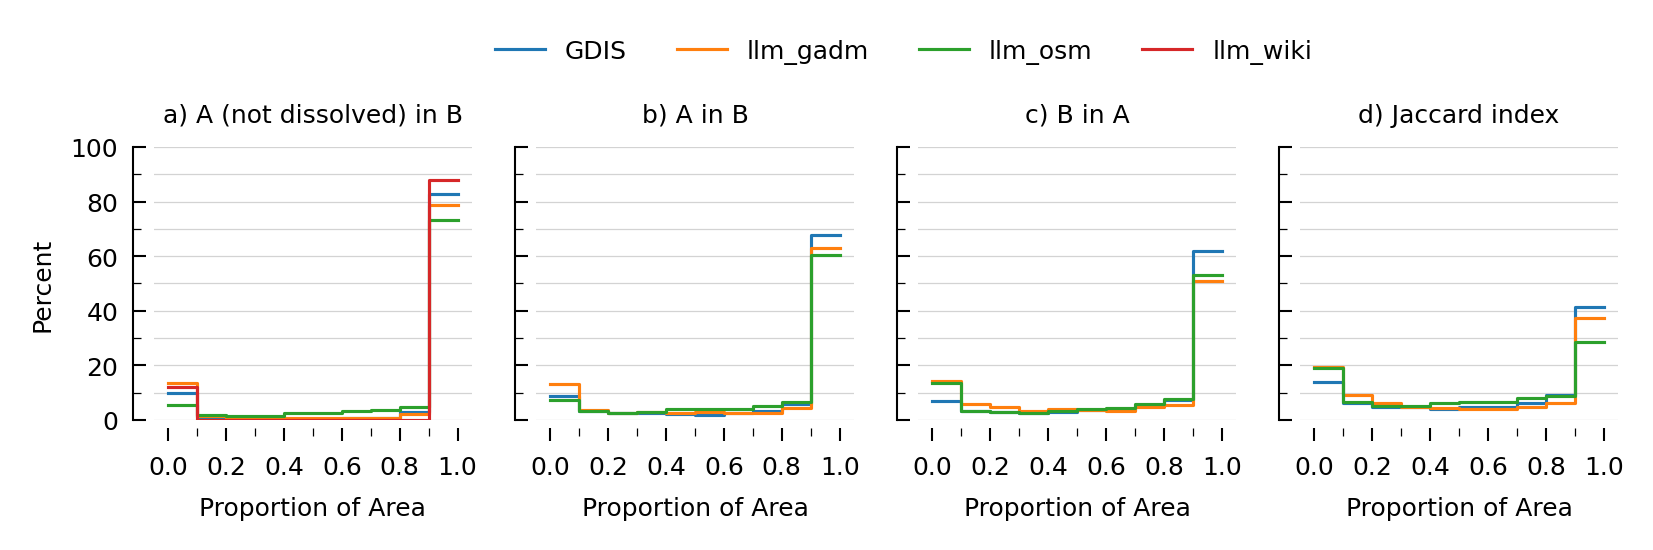

In [11]:
fig_row = {
    'GAUL': 0,
    'GDIS': 1
}

histplot_kwargs = {
    'element': 'step',
    'fill': False,
    'bins': BINS,
    'stat': 'percent', 
    'linewidth': 0.75
}

fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(16/2.54, 3/2.54))

for source, benchmark in combinations_gaul:
    print(benchmark)
    [ax0,ax1, ax2, ax3] = axes#[fig_row[benchmark], :]
    ax0.set_title("a) A (not dissolved) in B")#(f"{benchmark} (a in b)")
    ax1.set_title("b) A in B")#(f"{benchmark} (a in b)")
    ax2.set_title("c) B in A")#(f"{benchmark} (b in a)")
    ax3.set_title("d) Jaccard index")#(f"{benchmark} (Jaccard)")

    subset_data = output_data[(output_data['geom_type_a'] == source) & (output_data['geom_type_b'] == benchmark)]
    subset_data_dissolved = output_data_dissolved[(output_data_dissolved['geom_type_a'] == source) & (output_data_dissolved['geom_type_b'] == benchmark)]
    # print(f"{source} vs {benchmark}")
    # print(subset_data.head())

    sns.histplot(data=subset_data, x='a_in_b', ax=ax0, label=f'{source}', **histplot_kwargs) #(n={len(subset_data):,})
    if source != 'llm_wiki':
        sns.histplot(data=subset_data_dissolved, x='a_in_b', ax=ax1, label=f'{source}', **histplot_kwargs) # (n={len(subset_data_dissolved):,})
        sns.histplot(data=subset_data_dissolved, x='b_in_a', ax=ax2, label=f'{source}', **histplot_kwargs) # (n={len(subset_data_dissolved):,})
        sns.histplot(data=subset_data_dissolved, x='jaccard', ax=ax3, label=f'{source}', **histplot_kwargs) # (n={len(subset_data_dissolved):,})

def _format_ax(ax):
    ax.tick_params(
        axis='y',
        which='both',
        direction='in',
    )
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.xaxis.set_major_locator(MultipleLocator(.20))
    ax.xaxis.set_minor_locator(MultipleLocator(.10))
    ax.grid(which='both', axis='y', linestyle='-', linewidth=.3,
            color='lightgrey')
    ax.set_ylim((0, 100))
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 2))
    ax.set(xlabel ="Proportion of Area")
    return ax

for ax in axes.flatten():
    _format_ax(ax)
ax0.legend(loc='center left', ncol=4, title=None, frameon=False, bbox_to_anchor=(1, 1.35)) 


fig.tight_layout()

In [12]:
sel = output_data_dissolved[
    (output_data_dissolved['geom_type_a'] == 'llm_gadm') &
    (output_data_dissolved['geom_type_b'] == 'GAUL')
]
sel

,dis_no,name,admin_level,admin1,admin2,geom_type_a,geom_type_b,batch_number,area_calculation_method,area_a,...,jaccard,a_contains_b,b_contains_a,a_contains_b_properly,b_contains_a_properly,Start Year,Country,Region,Subregion,Disaster Type
5906,1999-9388-DJI,"['Ali Sabieh', 'Dikhil', 'Djibouti', 'Obock', ...","['Admin1', 'Admin1', 'Admin1', 'Admin1', 'Admi...","['Ali Sabieh', 'Dikhil', 'Djiboutii', 'Obock',...","[None, None, None, None, None]",llm_gadm,GAUL,1,geodetic,2.021281e+10,...,0.868855,False,False,False,False,2001,Djibouti,Africa,Sub-Saharan Africa,Drought
5907,1999-9388-SDN,"['Northern Darfur', 'Red Sea']","['Admin1', 'Admin1']","['North Darfur', 'Red Sea']","[None, None]",llm_gadm,GAUL,1,geodetic,5.337433e+11,...,0.661191,False,False,False,False,2000,Sudan,Africa,Northern Africa,Drought
5908,1999-9388-SOM,"['Bay', 'Hiraan', 'Ceel Barde', 'Rab Dhuure', ...","['Admin1', 'Admin1', 'Admin2', 'Admin2', 'Admi...","['Bay', 'Hiiraan', 'Bakool', 'Bakool', 'Bakool...","[None, None, 'Ceel Barde', 'Rab Dhuure', 'Tiye...",llm_gadm,GAUL,1,geodetic,1.238183e+11,...,0.985573,False,False,False,False,2000,Somalia,Africa,Sub-Saharan Africa,Drought
5909,2000-0002-AGO,['Baia Farta'],['Admin2'],['Benguela'],['Baía Farta'],llm_gadm,GAUL,1,geodetic,6.858307e+09,...,0.613666,False,False,False,False,2000,Angola,Africa,Sub-Saharan Africa,Flood
5910,2000-0003-BGD,"['Barisal', 'Chittagong', 'Dhaka', 'Khulna', '...","['Admin1', 'Admin1', 'Admin1', 'Admin1', 'Admi...","['Barisal', 'Chittagong', 'Dhaka', 'Khulna', '...","[None, None, None, None, None, None, None]",llm_gadm,GAUL,1,geodetic,1.288496e+11,...,0.895431,False,False,False,False,2000,Bangladesh,Asia,Southern Asia,Extreme temperature
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13504,2023-0459-IND,"['Maharashtra', 'Raigad']","['Admin1', 'Admin2']","['Maharashtra', 'Maharashtra']","[None, 'Pune']",llm_gadm,GAUL,5,geodetic,3.073389e+11,...,0.022390,False,False,False,False,2023,India,Asia,Southern Asia,Mass movement (wet)
13505,2023-0510-MNG,['Ulaanbaatar'],['Admin1'],['Ulaanbaatar'],[None],llm_gadm,GAUL,5,geodetic,4.531879e+09,...,0.777623,False,False,False,False,2023,Mongolia,Asia,Eastern Asia,Flood
13506,2023-0524-USA,"['Hawaii', 'Maui']","['Admin1', 'Admin2']","['Hawaii', 'Hawaii']","[None, 'Maui']",llm_gadm,GAUL,5,geodetic,1.672429e+10,...,0.992882,False,False,False,False,2023,United States of America,Americas,Northern America,Wildfire
13507,2023-0529-FRA,['Occitanie'],['Admin1'],['Occitanie'],[None],llm_gadm,GAUL,5,geodetic,7.327596e+10,...,0.055827,False,False,False,False,2023,France,Europe,Western Europe,Wildfire


<Axes: >

findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font f

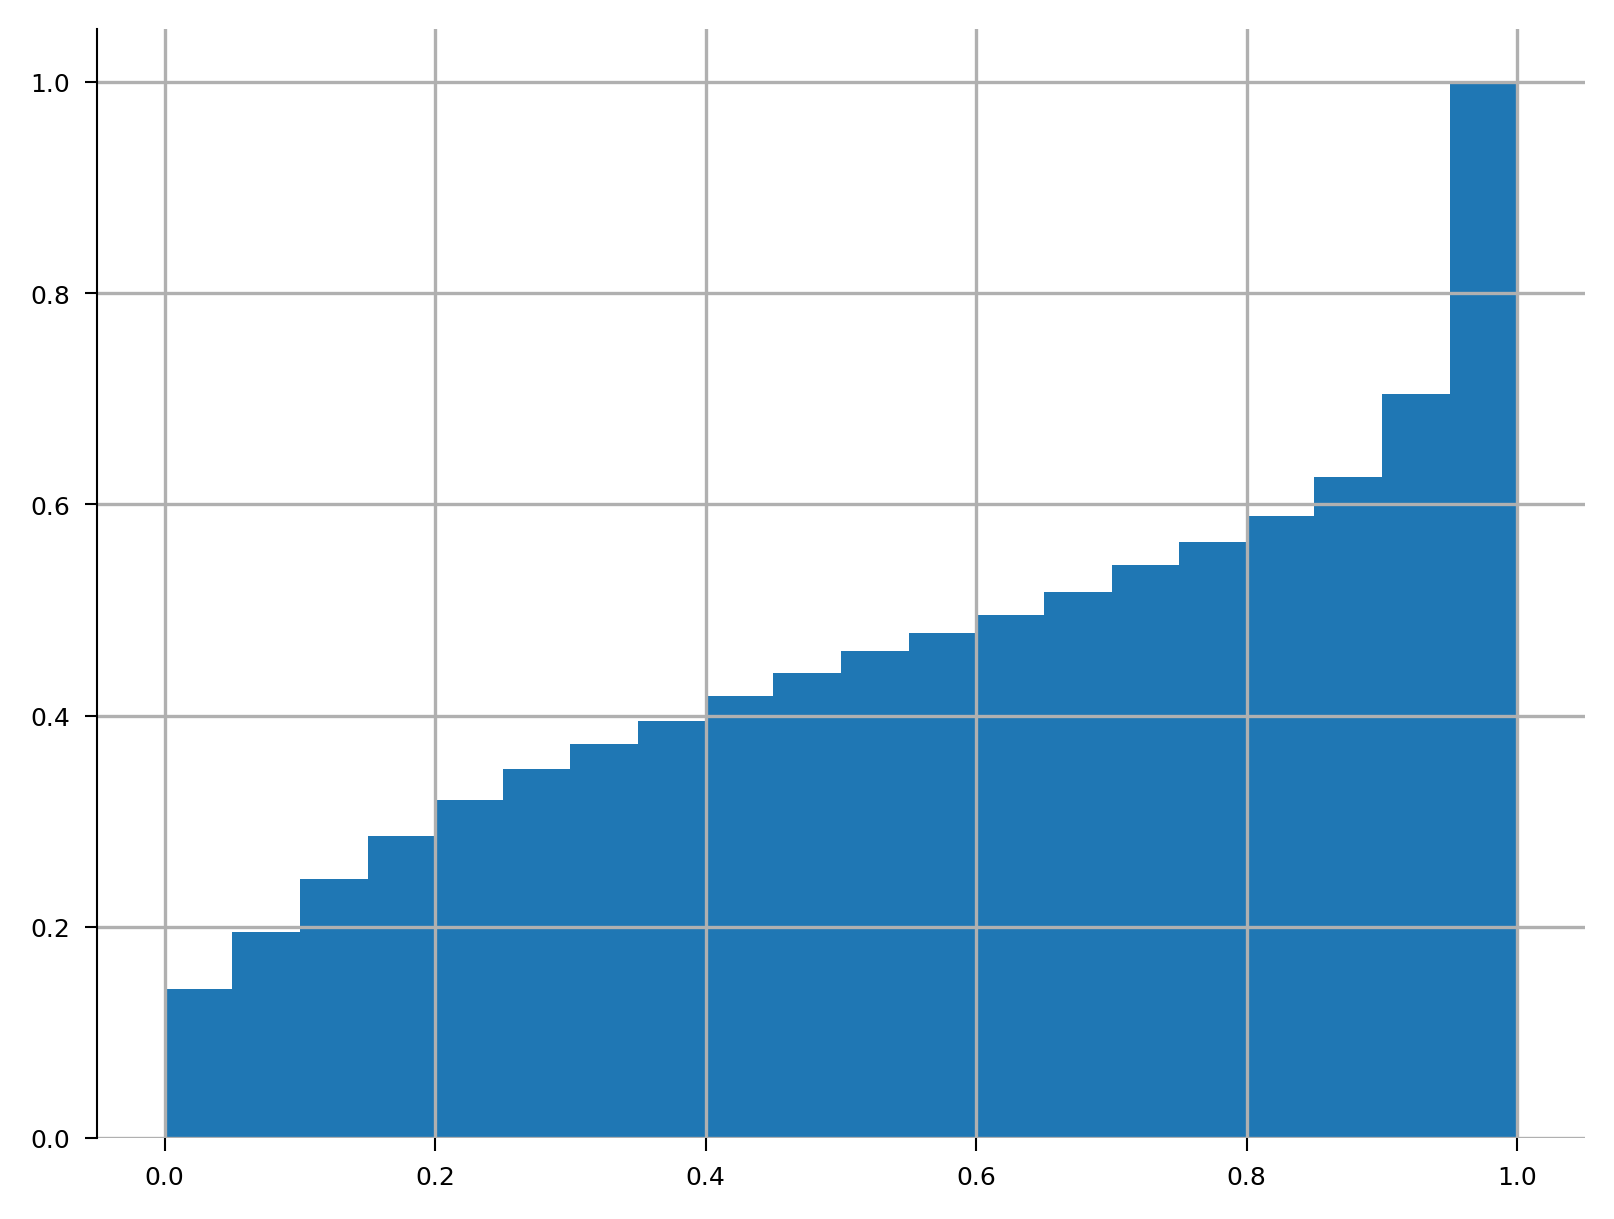

In [13]:
sel['jaccard'].hist(bins=20, density=True, cumulative=True)

C:\Users\wja209\AppData\Local\Temp\ipykernel_4160\1704041902.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_regions= pd.concat([results_regions,pd.DataFrame([[source, benchmark, region, a_in_b,jaccard]],columns=["a", "b", "Region", "a_in_b", "jaccard"])])
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos'

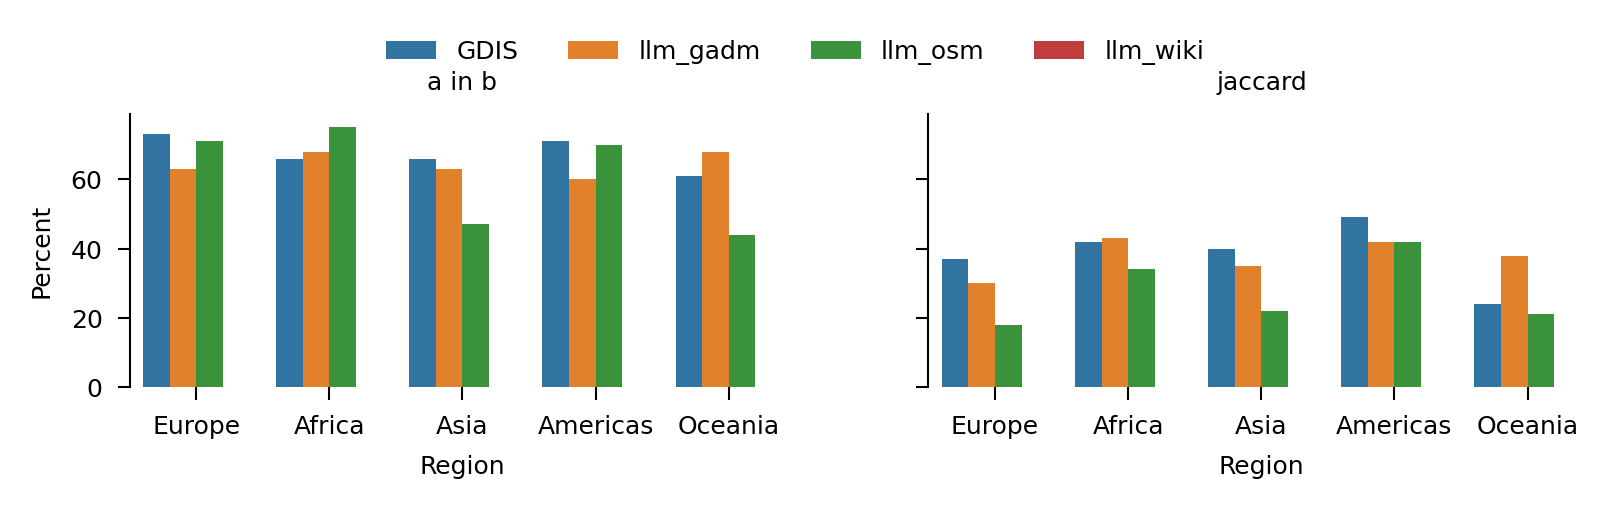

In [14]:
# Quick regional analysis
regions = output_data["Region"].unique()

results_regions = pd.DataFrame(columns=["Region", "a_in_b", "jaccard"])
for source, benchmark in combinations_gaul:
    subset_data_dissolved = output_data_dissolved[(output_data_dissolved['geom_type_a'] == source) & (output_data_dissolved['geom_type_b'] == benchmark)]
    for region in regions:
        region_filter = subset_data_dissolved["Region"] == region
        a_in_b = round(sum(subset_data_dissolved.loc[region_filter,"a_in_b"]>=0.9) / sum(subset_data_dissolved.loc[region_filter,"a_in_b"]>=0), 2)*100
        jaccard = round(sum(subset_data_dissolved.loc[region_filter,"jaccard"]>=0.9) / sum(subset_data_dissolved.loc[region_filter,"jaccard"]>=0), 2)*100

        results_regions= pd.concat([results_regions,pd.DataFrame([[source, benchmark, region, a_in_b,jaccard]],columns=["a", "b", "Region", "a_in_b", "jaccard"])])

fig, [ax1,ax2] = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16/2.54, 3/2.54))
sns.barplot(data=results_regions, x="Region", y="a_in_b", hue = "a", ax = ax1)
ax1.set(ylabel = "Percent", title= "a in b")

sns.barplot(data=results_regions, x="Region", y="jaccard", hue = "a", ax = ax2, legend = "")
ax2.set(ylabel = "Percent", title= "jaccard")

sns.move_legend(
    ax1, "lower center",
    bbox_to_anchor=(1, 1.1), ncol=4, title=None, frameon=False,
)

C:\Users\wja209\AppData\Local\Temp\ipykernel_4160\2195902820.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_years= pd.concat([results_years,pd.DataFrame([[source, benchmark, year, a_in_b,jaccard]],columns=["a", "b", "Year", "a_in_b", "jaccard"])])
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not fou

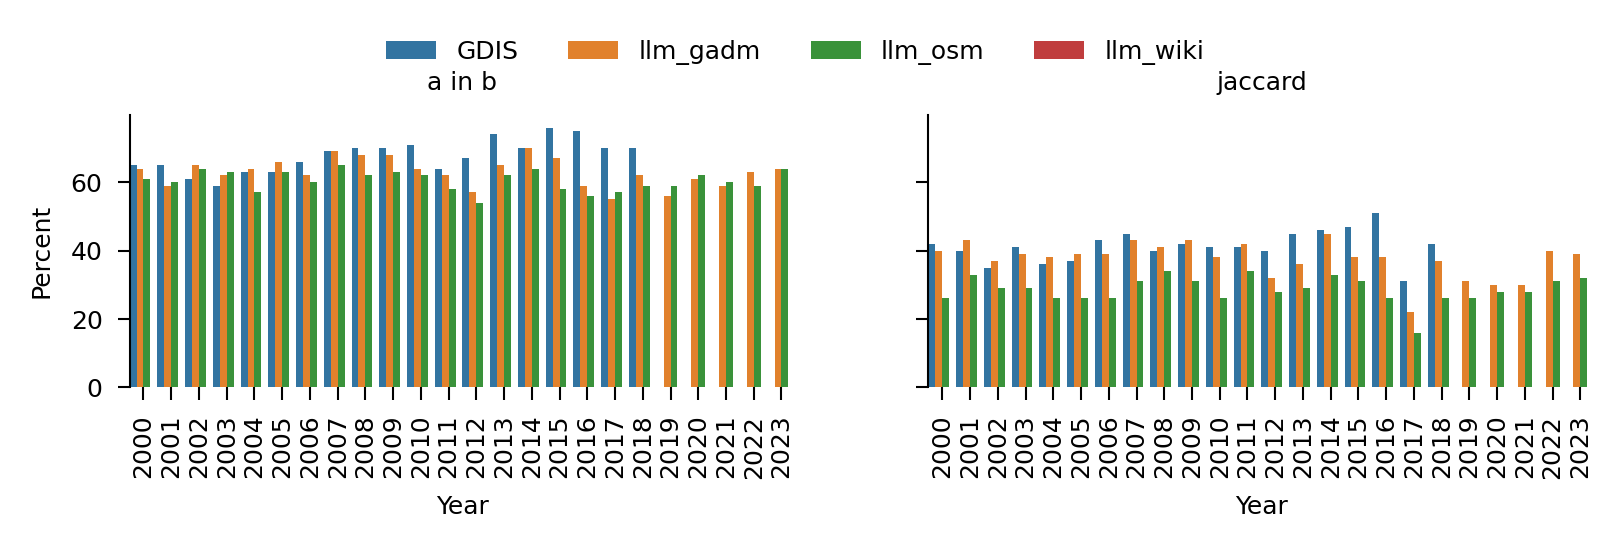

In [15]:
years = output_data["Start Year"].unique()
results_years = pd.DataFrame(columns=["Year", "a_in_b", "jaccard"])
for source, benchmark in combinations_gaul:
    subset_data_dissolved = output_data_dissolved[(output_data_dissolved['geom_type_a'] == source) & (output_data_dissolved['geom_type_b'] == benchmark)]
    for year in years:
        year_filter = subset_data_dissolved["Start Year"] == year
        a_in_b = round(sum(subset_data_dissolved.loc[year_filter,"a_in_b"]>=0.9) / max(sum(subset_data_dissolved.loc[year_filter,"a_in_b"]>=0),0.00001), 2) *100
        jaccard = round(sum(subset_data_dissolved.loc[year_filter,"jaccard"]>=0.9) / max(sum(subset_data_dissolved.loc[year_filter,"jaccard"]>=0), 0.0001), 2) *100

        results_years= pd.concat([results_years,pd.DataFrame([[source, benchmark, year, a_in_b,jaccard]],columns=["a", "b", "Year", "a_in_b", "jaccard"])])
results_years

fig, [ax1,ax2] = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16/2.54, 3/2.54))
sns.barplot(data=results_years, x="Year", y="a_in_b", hue = "a", ax = ax1, width=1)
ax1.set(ylabel = "Percent", title= "a in b")
ax1.tick_params(axis='x', rotation=90)

sns.barplot(data=results_years, x="Year", y="jaccard", hue = "a", ax = ax2, width=1, legend="")
ax2.set(ylabel = "Percent", title= "jaccard")
ax2.tick_params(axis='x', rotation=90)

sns.move_legend(
    ax1, "lower center",
    bbox_to_anchor=(1, 1.1), ncol=4, title=None, frameon=False,
)


C:\Users\wja209\AppData\Local\Temp\ipykernel_4160\3264124890.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_disaster_types= pd.concat([results_disaster_types,pd.DataFrame([[source, benchmark, disaster_type, a_in_b,jaccard]],columns=["a", "b", "Disaster Type", "a_in_b", "jaccard"])])
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
findfont: Font family 'Aptos' not found.
f

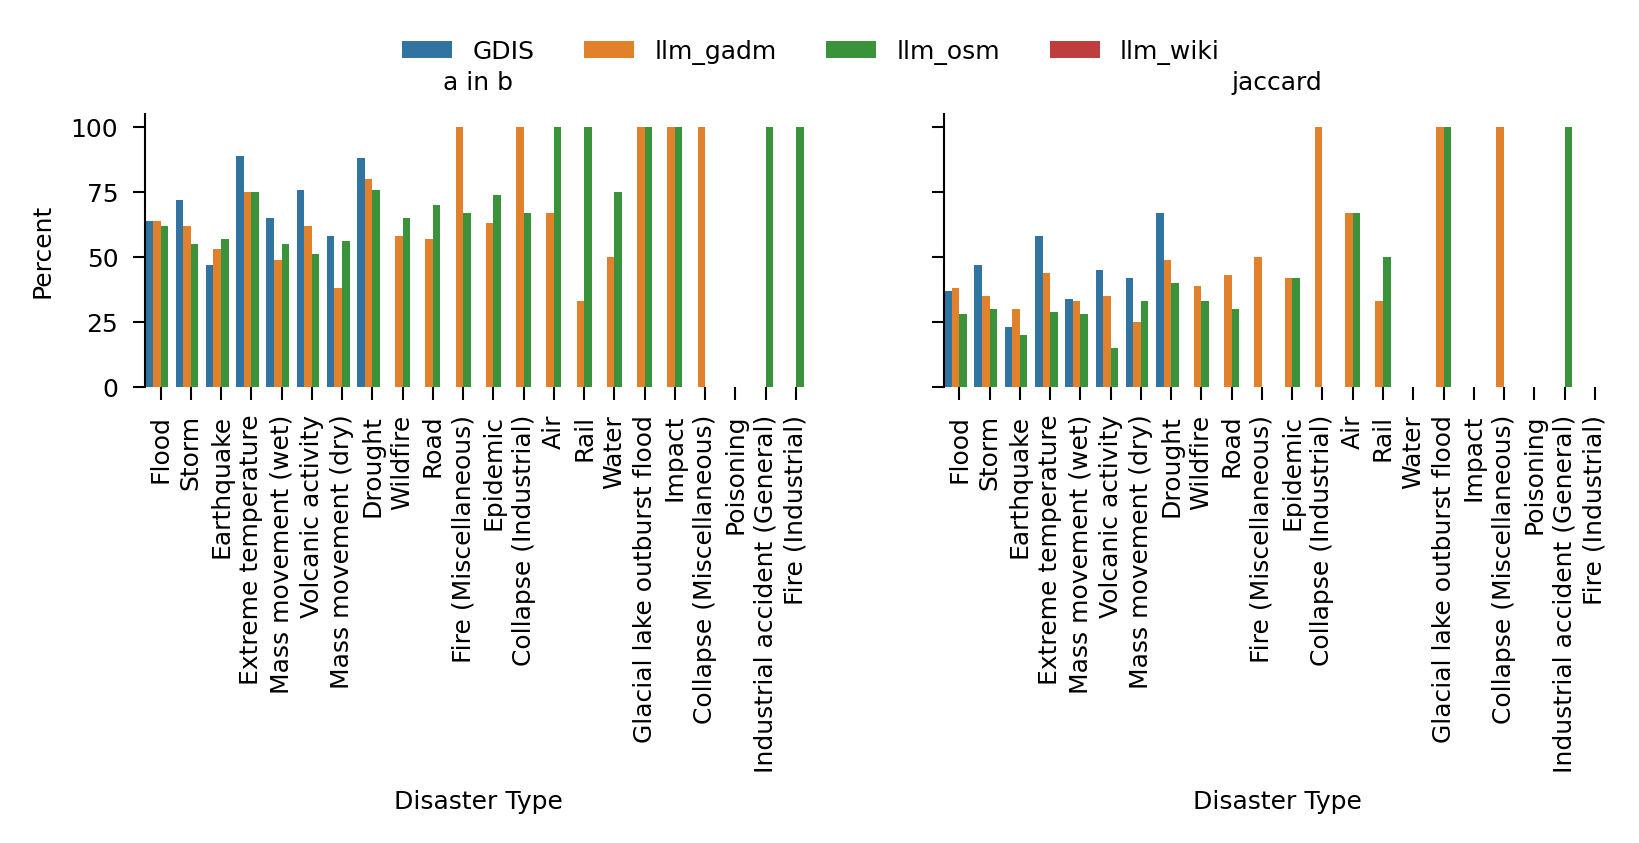

In [19]:
disaster_types = output_data["Disaster Type"].unique()
results_disaster_types = pd.DataFrame(columns=["Disaster Type", "a_in_b", "jaccard"])
for source, benchmark in combinations_gaul:
    subset_data_dissolved = output_data_dissolved[(output_data_dissolved['geom_type_a'] == source) & (output_data_dissolved['geom_type_b'] == benchmark)]
    for disaster_type in disaster_types:
        disaster_type_filter = subset_data_dissolved["Disaster Type"] == disaster_type
        a_in_b = round(sum(subset_data_dissolved.loc[disaster_type_filter,"a_in_b"]>=0.9) / max(sum(subset_data_dissolved.loc[disaster_type_filter,"a_in_b"]>=0),0.00001), 2) *100
        jaccard = round(sum(subset_data_dissolved.loc[disaster_type_filter,"jaccard"]>=0.9) / max(sum(subset_data_dissolved.loc[disaster_type_filter,"jaccard"]>=0), 0.0001), 2) *100

        results_disaster_types= pd.concat([results_disaster_types,pd.DataFrame([[source, benchmark, disaster_type, a_in_b,jaccard]],columns=["a", "b", "Disaster Type", "a_in_b", "jaccard"])])

fig, [ax1,ax2] = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16/2.54, 3/2.54))
sns.barplot(data=results_disaster_types, x="Disaster Type", y="a_in_b", hue = "a", ax = ax1, width=1)
ax1.set(ylabel = "Percent", title= "a in b")
ax1.tick_params(axis='x', rotation=90)

sns.barplot(data=results_disaster_types, x="Disaster Type", y="jaccard", hue = "a", ax = ax2, width=1, legend="")
ax2.set(ylabel = "Percent", title= "jaccard")
ax2.tick_params(axis='x', rotation=90)

sns.move_legend(
    ax1, "lower center",
    bbox_to_anchor=(1, 1.1), ncol=4, title=None, frameon=False,
)


In [18]:
output_data

,dis_no,name,admin_level,admin1,admin2,geom_type_a,geom_type_b,batch_number,area_calculation_method,area_a,...,jaccard,a_contains_b,b_contains_a,a_contains_b_properly,b_contains_a_properly,Start Year,Country,Region,Subregion,Disaster Type
0,2009-0631-ALB,Ana E Malit,AdminAdmin3,Shkoder,Shkodres,GDIS,GAUL,1,geodetic,4.387333e+07,...,0.054691,False,False,False,False,2009,Albania,Europe,Southern Europe,Flood
1,2009-0631-ALB,Bushat,AdminAdmin3,Shkoder,Shkodres,GDIS,GAUL,1,geodetic,5.942955e+07,...,0.069315,False,False,False,False,2009,Albania,Europe,Southern Europe,Flood
2,2001-0146-AGO,Onjiva,AdminAdmin3,Cunene,Cuanhama,GDIS,GAUL,1,geodetic,2.114110e+09,...,0.016538,False,True,False,True,2001,Angola,Africa,Sub-Saharan Africa,Flood
3,2009-0092-AGO,Evale,AdminAdmin3,Cunene,Cuanhama,GDIS,GAUL,1,geodetic,2.039397e+09,...,0.002673,False,True,False,True,2009,Angola,Africa,Sub-Saharan Africa,Flood
4,2009-0092-AGO,Mupa,AdminAdmin3,Cunene,Cuvelai,GDIS,GAUL,1,geodetic,2.166761e+09,...,0.002840,False,True,False,True,2009,Angola,Africa,Sub-Saharan Africa,Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181444,2014-0314-JPN,Kochi,Admin1,Kochi,NaN,llm_wiki,GDIS,5,geodetic,0.000000e+00,...,0.000000,False,True,False,True,2014,Japan,Asia,Eastern Asia,Storm
181445,2011-0432-DMA,Canefield,Admin3,St. Paul,NaN,llm_wiki,GDIS,5,geodetic,0.000000e+00,...,0.000000,False,True,False,True,2011,Dominica,Americas,Latin America and the Caribbean,Storm
181446,2011-0432-DMA,Coulibistrie,Admin3,St. Joseph,NaN,llm_wiki,GDIS,5,geodetic,0.000000e+00,...,0.000000,False,True,False,True,2011,Dominica,Americas,Latin America and the Caribbean,Storm
181447,2011-0432-DMA,Mahaut,Admin3,St. Paul,NaN,llm_wiki,GDIS,5,geodetic,0.000000e+00,...,0.000000,False,True,False,True,2011,Dominica,Americas,Latin America and the Caribbean,Storm
